<a href="https://colab.research.google.com/github/NSCC-ITC-Winter2024-DBAS5125-700-MCr/assignment-1-Adebayojosephine/blob/main/Assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Attrition using XGBoost

In [1]:
!pip install ydata-profiling
!pip install optuna
!pip install --upgrade xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 22.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=9a0e512c84c5268c7be24093f4aaf3019ed7a06071f5159aabe775697187fa42
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
     ━━━━━━━━━━━━━━━━

#  Import Libraries

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
import warnings
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")



# Load in data

In [3]:
data = pd.read_csv("/content/HR_Analytics.csv")

# Exploratory Data Analysis

In [4]:
data.head()

,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,3,80,0,0,2,3,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,1,80,0,0,2,3,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,4,80,0,0,3,3,0,0,0,0.0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,4,80,0,0,2,3,0,0,0,0.0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,4,80,0,0,0,3,0,0,0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmpID                     1480 non-null   object 
 1   Age                       1480 non-null   int64  
 2   AgeGroup                  1480 non-null   object 
 3   Attrition                 1480 non-null   object 
 4   BusinessTravel            1480 non-null   object 
 5   DailyRate                 1480 non-null   int64  
 6   Department                1480 non-null   object 
 7   DistanceFromHome          1480 non-null   int64  
 8   Education                 1480 non-null   int64  
 9   EducationField            1480 non-null   object 
 10  EmployeeCount             1480 non-null   int64  
 11  EmployeeNumber            1480 non-null   int64  
 12  EnvironmentSatisfaction   1480 non-null   int64  
 13  Gender                    1480 non-null   object 
 14  HourlyRa

In [6]:
data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,...,1480.000000,1480.0,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1423.000000
mean,36.917568,801.384459,9.220270,2.910811,1.0,1031.860811,2.724324,65.845270,2.729730,2.064865,...,2.708784,80.0,0.791892,11.281757,2.797973,2.760811,7.009459,4.228378,2.182432,4.118060
std,9.128559,403.126988,8.131201,1.023796,0.0,605.955046,1.092579,20.328266,0.713007,1.105574,...,1.081995,0.0,0.850527,7.770870,1.288791,0.707024,6.117945,3.616020,3.219357,3.555484
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,493.750000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,800.000000,7.000000,3.000000,1.0,1027.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1568.250000,4.000000,83.000000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [7]:
profile = ProfileReport(data, minimal=True)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Exploratory Data Analysis Visualization

In [8]:
# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Distribution of Monthly Income

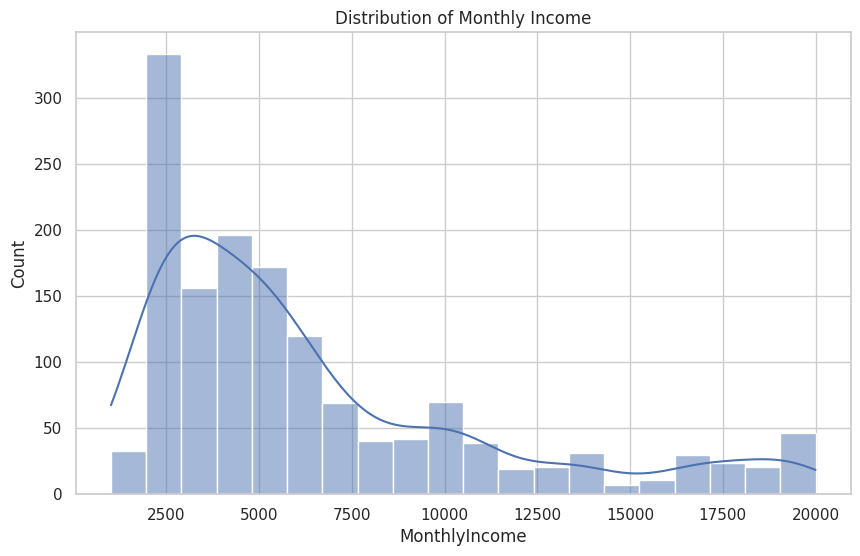

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data['MonthlyIncome'], kde=True)
plt.title('Distribution of Monthly Income')
plt.show()

# Total Working Years by Attrition

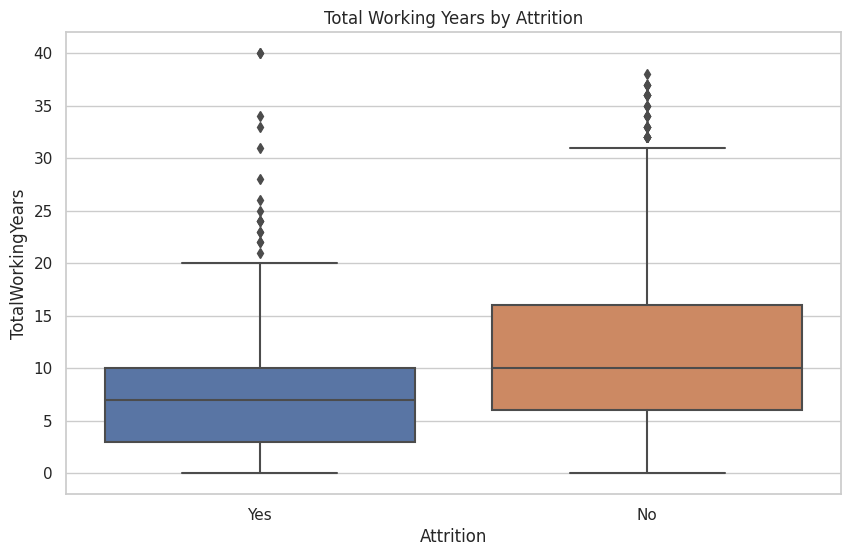

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='TotalWorkingYears', data=data)
plt.title('Total Working Years by Attrition')
plt.show()

# Heatmap to visualize missing values

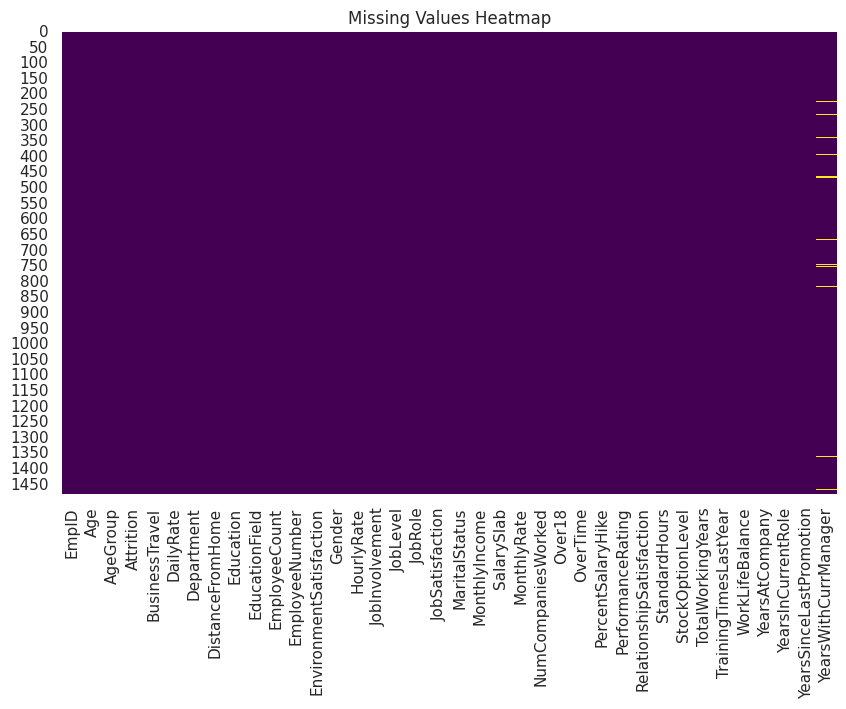

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Job Satisfaction by Monthly Income

In [12]:
violin_plot = px.violin(data, x='JobSatisfaction', y='MonthlyIncome', box=True, points="all", title='Job Satisfaction vs. Monthly Income')
violin_plot.show()

# Age distribution by Attrition

In [13]:
histogram = px.histogram(data, x='Age', color='Attrition', marginal='box', title='Age Distribution by Attrition')
histogram.show()

# Unique job roles

In [14]:
print(data['JobRole'].unique())

['Laboratory Technician' 'Sales Representative' 'Research Scientist'
 'Human Resources' 'Manufacturing Director' 'Sales Executive'
 'Healthcare Representative' 'Research Director' 'Manager']


# Preprocessing

# Check for missing values

In [15]:
missing_values = data.isnull().sum()
print(missing_values)

EmpID                        0
Age                          0
AgeGroup                     0
Attrition                    0
BusinessTravel               0
DailyRate                    0
Department                   0
DistanceFromHome             0
Education                    0
EducationField               0
EmployeeCount                0
EmployeeNumber               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                0
MonthlyIncome                0
SalarySlab                   0
MonthlyRate                  0
NumCompaniesWorked           0
Over18                       0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StandardHours                0
StockOptionLevel             0
TotalWorkingYears            0
Training

# Prepare the data

In [16]:
# Separation of features and target variables
X = data.drop(['EmpID', 'Attrition'], axis=1)
y = data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

In [17]:
# Identify columns (numerical or categorical)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Preprocessing pipeline

In [18]:
# Define preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split data into training and test sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Apply the preprocessor to transform the features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Construct Model and Evaluate

In [22]:
# Initialize and train the Logistic Regression model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Making predictions on the processed test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.88

Confusion Matrix:
[[235  14]
 [ 23  24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       249
           1       0.63      0.51      0.56        47

    accuracy                           0.88       296
   macro avg       0.77      0.73      0.75       296
weighted avg       0.87      0.88      0.87       296



# TRYING ANOTHER MODEL

In [23]:
# Load data
data = pd.read_csv("/content/HR_Analytics.csv")
data = data.rename(columns=str.lower)

# Prepare the data
X = data.drop(['empid', 'attrition'], axis=1)
y = data['attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Feature engineering functions
def total_experience(df):
    df['total_experience'] = df['totalworkingyears'] + df['yearsatcompany']
    return df

# Feature engineering pipeline
feature_engineering = ColumnTransformer([
    ('total_experience', FunctionTransformer(total_experience, validate=False),
     ['totalworkingyears', 'yearsatcompany']),
])

In [25]:
# Categorical and numerical columns
categorical_columns = list(X_train.select_dtypes(include=['object']).columns.values.tolist())
numeric_columns = list(X_train.select_dtypes(exclude=['object']).columns.values.tolist())

# Pipelines for numeric and categorical data
numeric_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])

In [26]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('feature_engineering', feature_engineering, numeric_columns),
        ('numeric_transformers', numeric_transformer, numeric_columns),
        ('categorical_transformers', categorical_transformer, categorical_columns),
    ])

In [27]:
# XGBoost model
model = XGBClassifier(random_state=0, eval_metric='mlogloss', tree_method='gpu_hist')

In [28]:
# Full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)])

In [29]:
# Fit and evaluate the base model
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print('Base Model - Accuracy:', accuracy_score(y_test, predictions))
print('Base Model - AUC:', roc_auc_score(y_test, predictions))
print('Base Model - Classification Report:\n', classification_report(y_test, predictions))

Base Model - Accuracy: 0.8648648648648649
Base Model - AUC: 0.6435102110569939
Base Model - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       249
           1       0.65      0.32      0.43        47

    accuracy                           0.86       296
   macro avg       0.77      0.64      0.68       296
weighted avg       0.85      0.86      0.84       296



In [30]:
# Optuna optimization function
def objective(trial):
    params = {
        'model__n_estimators': trial.suggest_int('model__n_estimators', 100, 1000),
        'model__learning_rate': trial.suggest_float('model__learning_rate', 0.01, 0.1),
        'model__max_depth': trial.suggest_int('model__max_depth', 3, 10),
        'model__min_child_weight': trial.suggest_int('model__min_child_weight', 1, 10),
        'model__gamma': trial.suggest_float('model__gamma', 0.01, 0.1),
        'model__subsample': trial.suggest_float('model__subsample', 0.01, 1.0),
        'model__colsample_bytree': trial.suggest_float('model__colsample_bytree', 0.01, 1.0),
        'model__reg_alpha': trial.suggest_float('model__reg_alpha', 1e-5, 10.0),
        'model__reg_lambda': trial.suggest_float('model__reg_lambda', 1e-5, 10.0),
        'model__scale_pos_weight': trial.suggest_float('model__scale_pos_weight', 1e-5, 10.0),
        'model__n_jobs': 4,
        'model__eval_metric': 'mlogloss',
        'model__tree_method': 'gpu_hist',
    }
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    return accuracy_score(y_test, predictions)

In [31]:
# Run Optuna optimization
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name='hr_analytics_model', direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)# Print the best parameters
print('Best parameters', study.best_params)
print('Best score', study.best_value)
print('Best model', study.best_trial)

  0%|          | 0/100 [00:00<?, ?it/s]

Best parameters {'model__n_estimators': 787, 'model__learning_rate': 0.06704712431475066, 'model__max_depth': 8, 'model__min_child_weight': 9, 'model__gamma': 0.048162583582627747, 'model__subsample': 0.3480351004314576, 'model__colsample_bytree': 0.5943106584518031, 'model__reg_alpha': 6.764308878319316, 'model__reg_lambda': 6.896663975192494, 'model__scale_pos_weight': 1.3408024490653327}
Best score 0.8952702702702703
Best model FrozenTrial(number=19, state=TrialState.COMPLETE, values=[0.8952702702702703], datetime_start=datetime.datetime(2024, 3, 1, 23, 3, 12, 614348), datetime_complete=datetime.datetime(2024, 3, 1, 23, 3, 13, 386129), params={'model__n_estimators': 787, 'model__learning_rate': 0.06704712431475066, 'model__max_depth': 8, 'model__min_child_weight': 9, 'model__gamma': 0.048162583582627747, 'model__subsample': 0.3480351004314576, 'model__colsample_bytree': 0.5943106584518031, 'model__reg_alpha': 6.764308878319316, 'model__reg_lambda': 6.896663975192494, 'model__scale_p

In [32]:
# Re-fit the model using the best parameters
pipeline.set_params(**study.best_params)
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

In [33]:
# Evaluate the optimized model
print('Optimized Model - Accuracy:', accuracy_score(y_test, predictions))
print('Optimized Model - AUC:', roc_auc_score(y_test, predictions))
print('Optimized Model - Classification Report:\n', classification_report(y_test, predictions))

Optimized Model - Accuracy: 0.8952702702702703
Optimized Model - AUC: 0.7306246261642314
Optimized Model - Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       249
           1       0.77      0.49      0.60        47

    accuracy                           0.90       296
   macro avg       0.84      0.73      0.77       296
weighted avg       0.89      0.90      0.89       296



In [34]:
# DATA FOUND IN KAGGLE
# https://www.kaggle.com/datasets/anshika2301/hr-analytics-dataset?select=HR_Analytics.csv